# Lab 03 - Pitches

---
embed-resources: true
---

## Introduction

The purpose of this report is to update the model that assists with displaying real-time pitch classifications, for both display in the stadium and on television broadcasts. The goal is to acheive a high classification accuracy to add to the viewing experience of the game. This report makes use of a k-nearest neighbors classifier trained on data from pitches thrown by Shohei Ohtani.

## Methods

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from joblib import dump

### Data

In [2]:
# load data
pitches_train = pd.read_parquet(
    "https://cs307.org/lab/data/pitches-train.parquet",
)
pitches_test = pd.read_parquet(
    "https://cs307.org/lab/data/pitches-test.parquet",
)

# create X and y for train
X_train = pitches_train.drop("pitch_name", axis=1)
y_train = pitches_train["pitch_name"]

# create X and y for test
X_test = pitches_test.drop("pitch_name", axis=1)
y_test = pitches_test["pitch_name"]

The data contains information about pitches thrown by Shohei Ohtani. Each row represents one pitch thrown during a game. The training data is the 2022 MLB season and the test data is the first half of the 2023 MLB season. The data dictionary is detailed below.

### Response
**`pitch_name`**
- [object] the name of the pitch, which is the name of the pitch type thrown

### Features
**`release_speed`**
- [float64] pitch velocity (miles per hour) measured shortly after leaving the pitcher’s hand

**`release_spin_rate`**
- [float64] pitch spin rate (revolutions per minute) measured shortly after leaving the pitcher’s hand

**`pfx_x`**
- [float64] horizontal movement (feet) of the pitch from the catcher’s perspective.

**`pfx_z`**
- [float64] vertical movement (feet) of the pitch from the catcher’s perspective.

**`stand`**
- [object] side of the plate batter is standing, either L (left) or R (right)

In [3]:
# summary statistics
pitches_train

,pitch_name,release_speed,release_spin_rate,pfx_x,pfx_z,stand
0,Sweeper,84.7,2667.0,1.25,0.01,R
1,Sweeper,83.9,2634.0,1.41,0.20,R
2,Sweeper,84.4,2526.0,1.26,0.25,R
3,Curveball,74.3,2389.0,0.93,-1.10,L
4,Sweeper,85.6,2474.0,1.08,0.52,R
...,...,...,...,...,...,...
2623,Split-Finger,91.8,1314.0,-0.30,0.08,R
2624,Sweeper,86.9,2440.0,1.11,0.51,R
2625,4-Seam Fastball,99.2,2320.0,0.04,0.81,R
2626,4-Seam Fastball,97.9,2164.0,0.08,1.06,R


The training dataset has 2628 samples and 5 features

In [4]:
pd.concat([y_train.value_counts(), y_train.value_counts(normalize=True)], axis=1)

,count,proportion
pitch_name,,
Sweeper,983,0.374049
4-Seam Fastball,718,0.273212
Split-Finger,312,0.118721
Cutter,233,0.088661
Curveball,222,0.084475
Sinker,97,0.036910
Slider,63,0.023973


We see that `Sweeper` and `4-Seam Fastball` are by far the most common pitches and `Sinker` and `Slider` are quite uncommon. `Split-Finger`, `Cutter`, and `Curveball` are in between.

In [5]:
mean_speed_by_pitch = pitches_train[['pitch_name', 'release_speed']].groupby('pitch_name').agg('mean').rename(columns={"release_speed": "release_speed_mean"})
std_speed_by_pitch = pitches_train[['pitch_name', 'release_speed']].groupby('pitch_name').agg('std').rename(columns={"release_speed": "release_speed_std"})
pd.concat([mean_speed_by_pitch, std_speed_by_pitch], axis=1)

,release_speed_mean,release_speed_std
pitch_name,,
4-Seam Fastball,97.270613,1.699270
Curveball,77.679730,3.215206
Cutter,90.742060,2.364489
Sinker,97.160825,1.829592
Slider,85.203175,2.401543
Split-Finger,89.291346,1.759299
Sweeper,85.336419,1.862552


Each pitch type seems to have a distinct `release_speed` distribution, which means that our model will likely perform quite well.

In [6]:
mean_spin_by_pitch = pitches_train[['pitch_name', 'release_spin_rate']].groupby('pitch_name').agg('mean').rename(columns={"release_spin_rate": "release_spin_mean"})
std_spin_by_pitch = pitches_train[['pitch_name', 'release_spin_rate']].groupby('pitch_name').agg('std').rename(columns={"release_spin_rate": "release_spin_std"})
pd.concat([mean_spin_by_pitch, std_spin_by_pitch], axis=1)

,release_spin_mean,release_spin_std
pitch_name,,
4-Seam Fastball,2217.331933,114.754683
Curveball,2482.666667,119.854726
Cutter,2378.424893,206.685887
Sinker,1972.747368,143.920632
Slider,2497.619048,78.679306
Split-Finger,1273.560897,221.291146
Sweeper,2492.172940,103.176892


Each pitch type also seems to have a distinct `release_spin_rate` distribution, which means that our model will likely perform quite well.

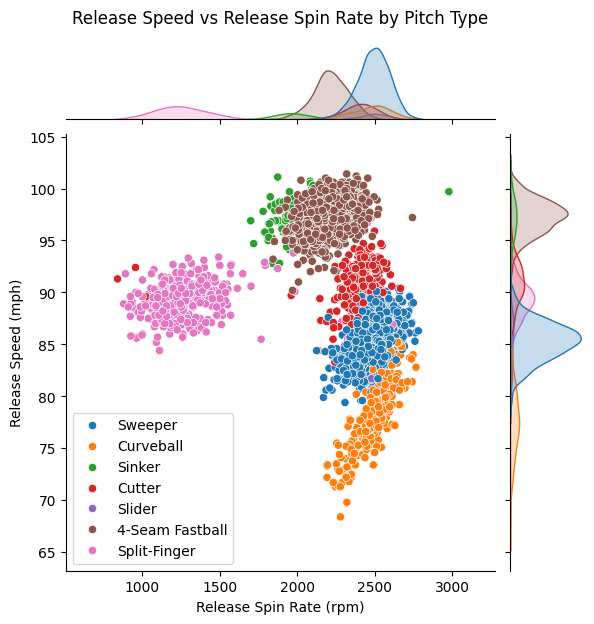

In [7]:
# exploratory visualization
sns.jointplot(x='release_spin_rate',y='release_speed',hue='pitch_name',data=pitches_train)
plt.title("Release Speed vs Release Spin Rate by Pitch Type", pad=80)
plt.xlabel("Release Spin Rate (rpm)")
plt.ylabel("Release Speed (mph)")
plt.legend()

We can see that most pitches can be readily differentiated into their pitch type using `release_speed` and `release_spin_rate`.

### Models

In [8]:
# define variables
numeric_features  = ['release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z']
categorical_features = ['stand']
features = numeric_features + categorical_features
target = 'pitch_name'

In [9]:
# preprocessing
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
)
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='infrequent_if_exist')
)
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    remainder='drop',
)

For all the numeric variables we will impute missing values with the median and then scale them. For all categorical variables, we will impute missing values with the most frequent value and we will one-hot encode them.

In [10]:
# model selection
k_values = [3, 5, 10, 15, 20, 50]
v_train, validation = train_test_split(pitches_train, test_size=0.2, random_state=307)
X_v_train = v_train[features]
Y_v_train = v_train[target]
X_validation = validation[features]
Y_validation = validation[target]
for k in k_values:
    model = make_pipeline(
        preprocessor, 
        KNeighborsClassifier(n_neighbors=k,p=1)
    )
    _ = model.fit(X_v_train, Y_v_train)
    score = accuracy_score(Y_validation, model.predict(X_validation))
    print(f"Accuracy Score for k={k} is {score}")

Accuracy Score for k=3 is 0.9790874524714829
Accuracy Score for k=5 is 0.9790874524714829
Accuracy Score for k=10 is 0.9809885931558935
Accuracy Score for k=15 is 0.9809885931558935
Accuracy Score for k=20 is 0.9809885931558935
Accuracy Score for k=50 is 0.9657794676806084


Based on fitting six different models with different values of k and comparing their validation accuracy scores, we will select k=15 for our final model.

In [11]:
# final model
model = make_pipeline(
    preprocessor,
    KNeighborsClassifier(n_neighbors=15,p=1)
)
_ = model.fit(pitches_train[features], pitches_train[target])

## Results

In [12]:
# report model metrics
y_true = pitches_test[target]
y_pred = model.predict(pitches_test[features])
accuracy_score(y_true, y_pred)

0.9409956976029502

The accuracy score on the test dataset is 94.1%

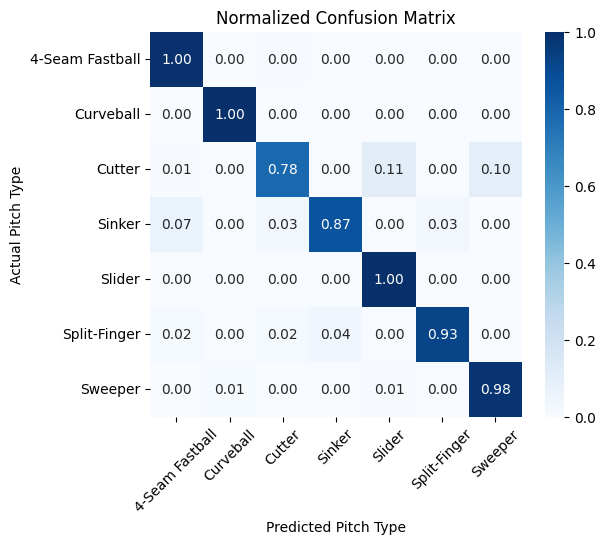

In [13]:
# confusion matrix summary figure
labels = sorted(set(y_true).union(set(y_pred)))
cm = confusion_matrix(y_true, y_pred, labels=labels)
plt.figure(figsize=(6, 5))
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Pitch Type")
plt.ylabel("Actual Pitch Type")
plt.title("Normalized Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

This plot shows that the model is quite accurate at predicting each pitch type. The only notable exception is that `Cutter` is sometimes misclassified as either a `Slider` or a `Sweeper`.

In [14]:
# serialize model
dump(model, 'pitches.joblib')

['pitches.joblib']

## Discussion

I would recommend that this model be put into practice. The accuracy is quite high at 94.1%, and even when a pitch is misclassified, there will be no meaningful consequence. The two most common pitch types, Sweeper and 4-Seam Fastball, are classified correctly 100% and 98% of the time, respectively. Cutter, the most often misclassified pitch type (but still 78% accurate), only represents about 8% of total pitches. Given that it is quite hard for a computer to correctly classify this type of pitch, it is very unlikely that a baseball fan will recognize it, and then call out that a classification error has been made. Even in that event, there are no threats posed to revenue or safety. Therefore, because this model is quite accurate and because there are virtually no disadvantages to implementing it, I recommend that it be put into practice right away.